## 验证磨合过程中的样本相关性与多马尔可夫链采样策略

### 目标

1. 验证在马尔可夫链的磨合（Burn-in）过程中，连续的样本之间高度相关。
2. 同时运行多个马尔可夫链（例如 100 条），并从这些固定的马尔可夫链  
集合中抽取所需要的样本，模拟小批量采样的策略。

### 背景介绍

在马尔可夫链蒙特卡罗方法（MCMC）中，马尔可夫链需要经过一定的磨合时间才能达到平稳分布。  
在磨合过程中，连续的样本之间通常高度相关，这会影响采样的有效性。为了提高采样效率，常常  
采用同时运行多条马尔可夫链的方法，这些链的数量通常与小批量（minibatch）的样本数相近，例如 100。


### 实现步骤

#### 1. 验证磨合过程中的样本相关性：

- 使用一个简单的马尔可夫链模型（如一维高斯分布上的随机游走）进行模拟。
- 记录磨合过程中的样本，计算连续样本之间的自相关性，验证在磨合过程中样本高度相关。

#### 2. 多马尔可夫链采样策略：

- 使用 PyTorch 同时运行多条马尔可夫链（如 100 条）。
- 从这些固定的马尔可夫链集合中抽取所需要的样本，模拟小批量采样的策略。
- 展示如何使用这些样本进行后续的计算或训练。


## 代码解释

### 1. Metropolis-Hastings 采样

- **目标分布 `target_distribution(x)`**：  
  目标分布是标准正态分布，其概率密度函数用于 Metropolis-Hastings 算法的接受率计算。

- **Metropolis-Hastings 算法 `metropolis_hastings()`**：
  - 使用对称的正态分布作为提议分布。
  - 初始状态设为远离目标分布高密度区域的值（如 10.0），以模拟磨合过程。
  - 在每次迭代中，根据接受概率更新当前样本。

- **自相关性计算 `autocorrelation(x)`**：
  - 计算样本序列的自相关函数，观察不同滞后（lag）下样本的相关性。
  - 自相关性越高，表明样本之间的相关性越强，表示马尔可夫链仍处于磨合期。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 目标分布：标准正态分布的概率密度函数
def target_distribution(x):
    return (1/np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# Metropolis-Hastings算法实现
def metropolis_hastings(target_pdf, proposal_std, initial_state, iterations):
    samples = [initial_state]
    current_state = initial_state

    for i in range(iterations):
        # 从提议分布（对称的正态分布）中采样候选点
        proposed_state = np.random.normal(current_state, proposal_std)

        # 计算接受概率
        acceptance_ratio = target_pdf(proposed_state) / target_pdf(current_state)
        acceptance_probability = min(1, acceptance_ratio)

        # 决定是否接受候选点
        if np.random.rand() < acceptance_probability:
            current_state = proposed_state  # 接受候选点
        else:
            pass  # 保持当前状态

        samples.append(current_state)

    return np.array(samples)

# 参数设置
proposal_std = 1.0     # 提议分布的标准差
initial_state = 10.0   # 初始状态，远离目标分布的高密度区域
iterations = 5000      # 迭代次数

# 运行Metropolis-Hastings算法
samples = metropolis_hastings(target_distribution, proposal_std, initial_state, iterations)

# 计算自相关性
def autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x - x.mean()
    r = np.correlate(x, x, mode='full')[-n:]
    result = r / (variance * np.arange(n, 0, -1))
    return result

autocorr = autocorrelation(samples)


### 结果分析

- **采样值的轨迹**：  
  在初始阶段，样本值逐渐向目标分布的高密度区域移动，展示了磨合过程。
  
- **自相关性图**：  
  在磨合阶段，自相关性较高，随着滞后增大，自相关性逐渐降低，表明样本逐渐达到平稳分布。


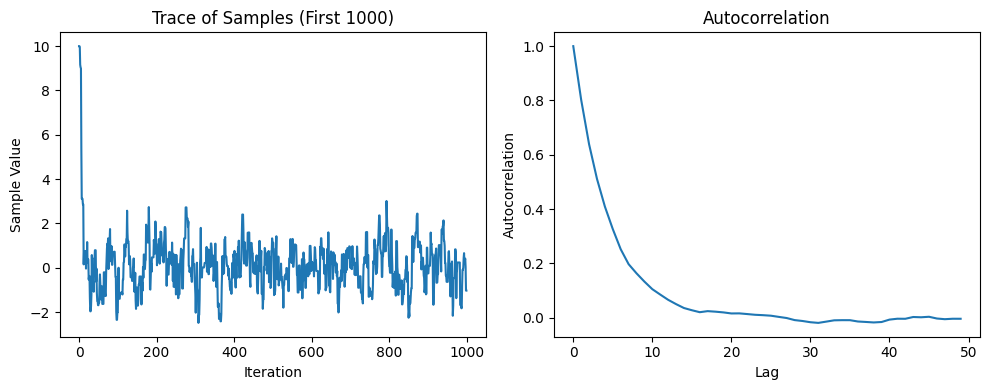

In [5]:
# 绘制结果
plt.figure(figsize=(10, 4))

# 子图1：采样值的轨迹
plt.subplot(1, 2, 1)
plt.plot(samples[:1000])
plt.title('Trace of Samples (First 1000)')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')

# 子图2：自相关性
plt.subplot(1, 2, 2)
plt.plot(autocorr[:50])
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()
plt.show()


### 2. 多马尔可夫链采样策略

- 使用 PyTorch 同时运行多条马尔可夫链（例如 100 条），从这些链中抽取样本，模拟小批量采样策略。
- 通过同时运行多条链，可以提高采样效率，避免单条链的采样结果高度相关。
- 最后提取每条链中的样本用于后续计算或训练。


## 代码解释

### 目标分布 `target_distribution(x)`：

- **二维标准正态分布**：  
  目标分布是二维标准正态分布，用于 Metropolis-Hastings 算法中的接受率计算。

### Metropolis-Hastings 算法向量化实现 `metropolis_hastings_vectorized()`：

- **初始状态**：  
  同时初始化 `num_chains` 条马尔可夫链，每条链的初始状态不同，通常从随机分布中采样。
  
- **向量化操作**：  
  利用 PyTorch 的张量操作，在一次运算中同时更新多个链的状态，从而提高计算效率。
  
- **接受步骤**：  
  对于每条链，独立地计算接受率，并决定是否接受候选状态。这个过程在多个链上并行完成。

### 采样结果处理：

- **磨合期**：  
  设置磨合期 `burn_in`，在采样过程中丢弃初始的样本，以确保剩下的样本来自平稳分布。
  
- **最终样本**：  
  将经过磨合的样本展平，用于后续的分析或训练。

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 定义目标分布：二维标准正态分布
def target_distribution(x):
    return torch.exp(-0.5 * torch.sum(x**2, dim=1)) / (2 * np.pi)

# Metropolis-Hastings算法（向量化版本）
def metropolis_hastings_vectorized(target_pdf, proposal_std, initial_states, iterations):
    num_chains, dim = initial_states.shape
    samples = torch.zeros(iterations, num_chains, dim)
    current_states = initial_states

    for i in range(iterations):
        # 从提议分布中采样候选点
        proposed_states = current_states + torch.randn(num_chains, dim) * proposal_std

        # 计算接受概率
        current_probs = target_pdf(current_states)
        proposed_probs = target_pdf(proposed_states)
        acceptance_ratios = proposed_probs / current_probs
        acceptance_probs = torch.min(acceptance_ratios, torch.ones(num_chains))

        # 决定是否接受候选点
        uniforms = torch.rand(num_chains)
        accept = uniforms < acceptance_probs

        # 更新状态
        current_states = torch.where(accept.unsqueeze(1), proposed_states, current_states)

        samples[i] = current_states

    return samples

# 参数设置
proposal_std = 0.5             # 提议分布的标准差
num_chains = 100               # 马尔可夫链的数量
dim = 2                        # 维度
iterations = 500               # 迭代次数
initial_states = torch.randn(num_chains, dim) * 5.0  # 初始状态，远离目标分布高密度区域

# 运行Metropolis-Hastings算法
samples = metropolis_hastings_vectorized(target_distribution, proposal_std, initial_states, iterations)

# 取最后的样本（假设已经过了磨合期）
burn_in = 100  # 磨合期
final_samples = samples[burn_in:].reshape(-1, dim).numpy()



### 结果分析：

- **采样轨迹图**：  
  展示部分链的采样轨迹。在磨合过程中，链逐渐从初始状态移动到目标分布的高密度区域，形成稳定的分布。

- **最终样本分布图**：  
  绘制经过磨合后的样本分布图，理想情况下，样本应接近目标分布。


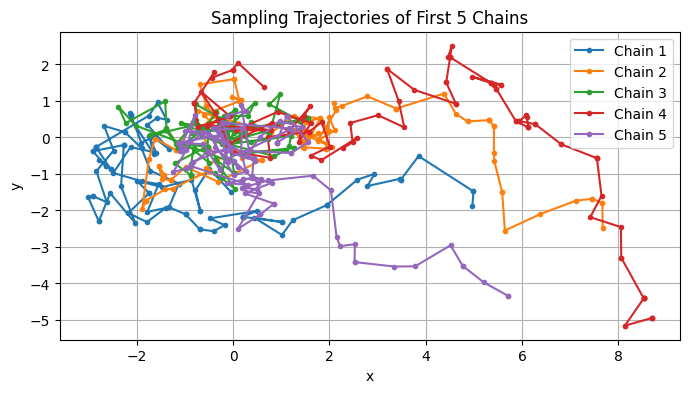

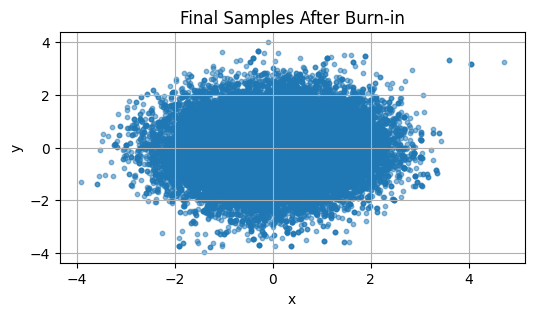

In [10]:
# 可视化结果
plt.figure(figsize=(8, 4))

# 子图1：展示部分链的采样轨迹
for i in range(5):
    plt.plot(samples[:100, i, 0].numpy(), samples[:100, i, 1].numpy(), '-o', markersize=3, label=f'Chain {i+1}')
plt.title('Sampling Trajectories of First 5 Chains')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# 子图2：绘制最终采样得到的分布
plt.figure(figsize=(6, 3))
plt.scatter(final_samples[:, 0], final_samples[:, 1], alpha=0.5, s=10)
plt.title('Final Samples After Burn-in')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

### 总结

- **磨合过程中的样本高度相关性**：  
  在 Metropolis-Hastings 算法的初始阶段，连续样本之间自相关性较高，随着迭代的进行，自相关性逐渐降低。

- **多马尔可夫链采样策略**：  
  同时运行多个马尔可夫链，可以模拟小批量采样的策略，有效提高采样效率。

### 注意事项：

1. **磨合期的选择**：  
   磨合期的长度需要根据具体情况确定，磨合期过短可能导致样本未达到平稳分布，而过长则会增加计算开销。

2. **链之间的独立性**：  
   初始状态应尽可能保证每条马尔可夫链彼此独立，以提高采样的多样性和覆盖性。

